In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

In [ ]:
stock_data = yf.download('AAPL', start='2012-01-01', end='2022-01-01')
df = stock_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Close
Date,
2012-01-09,14.905928
2012-01-10,14.991714
2012-01-11,15.056786
2012-01-12,15.080786
2012-01-13,15.062285


In [ ]:

df['Close'] = df['Close'].rolling(window=5).mean()
df.dropna(inplace=True)

<ipython-input-3-4a8a306a526a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = df['Close'].rolling(window=5).mean()
<ipython-input-3-4a8a306a526a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)  # Drop NaN values created by the moving average


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [ ]:

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.1374e-04 - val_loss: 8.5480e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.8379e-04 - val_loss: 0.0013
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.4142e-04 - val_loss: 7.0176e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 1.5686e-04 - val_loss: 7.5739e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 1.2980e-04 - val_loss: 7.2232e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.3210e-04 - val_loss: 6.5227e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 8.8916e-05 - val_loss: 6.0242e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.6150e-05 - val_loss: 5.4836e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.4940e-05 - val_loss: 5.1231e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.1037e-

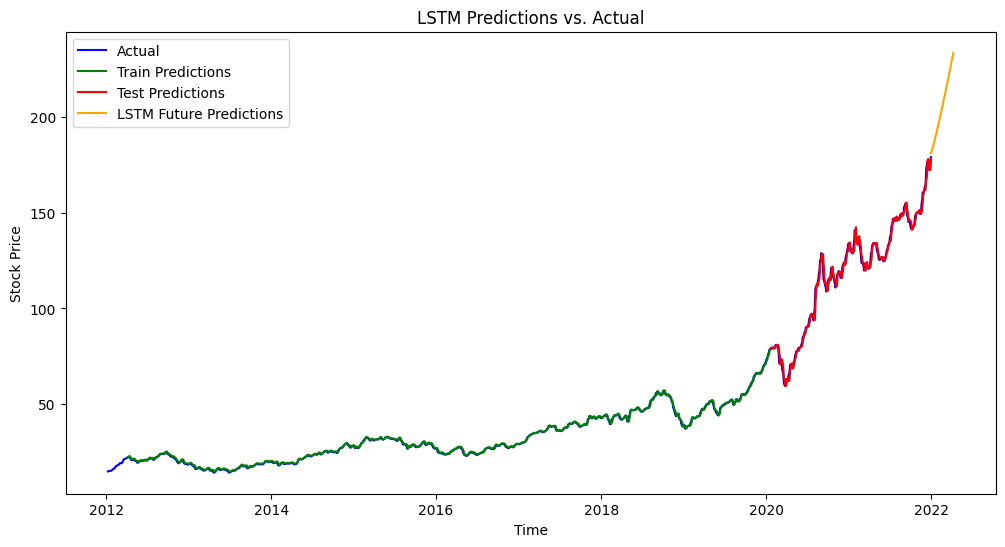

In [ ]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stop], verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])


train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


n_future = 100
last_sequence = scaled_data[-time_step:]
predictions = []

for _ in range(n_future):
    next_prediction = model.predict(last_sequence.reshape(1, time_step, 1))
    predictions.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[1:], next_prediction, axis=0)

predictions = np.array(predictions)
future_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))


plt.figure(figsize=(12,6))

plt.plot(df.index, df['Close'], label='Actual', color='blue')

plt.plot(df.index[time_step:time_step + len(train_predict)], train_predict, color='green', label='Train Predictions')

plt.plot(df.index[-len(test_predict):], test_predict, color='red', label='Test Predictions')


future_dates = pd.date_range(df.index[-1], periods=n_future, freq='D')
plt.plot(future_dates, future_predictions, color='orange', label='LSTM Future Predictions')

plt.legend()
plt.title('LSTM Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()